# Stream Spring
The point of this notebook is to try and do a proof of concept about streaming results out of genesis calculations. We will setup a run using the Genesis code to go in the background. Then we will create a loop which reads the trajectory file. If there's something new there, it will create new runs for BigDFT to starting calculating.

In [1]:
remote_dir = "/home/dawson/Genesis/runs/stream"
local_dir = "stream"

We run Genesis on the GPU side.

In [2]:
from computers import gpu
gpu.conda = "genesis"
gpu.parittion = "autumn06"
gpu.omp = 1
gpu.mpi = 1
gpu.partition = "autumn06"

BigDFT on the CPU side.

In [3]:
from computers import cpu
cpu.conda = "genesis"
cpu.cpu = 36
cpu.omp = 9
cpu.mpi = 4

Extract on the front end.

In [4]:
from computers import front
front.conda = "genesis"

## Dataset Setups
First we need to get the Genesis calculation running in the background.

In [5]:
from remotemanager import Dataset
from calcs import calc_genesis
dsg = Dataset(calc_genesis, url=gpu, name="calc_genesis",
             extra_files_send=["inp", "toppar"],
             remote_dir=remote_dir, local_dir=local_dir)
dsg.append_run({"geom": "1uao"})

runner runner-0 already exists


This will feed into a BigDFT run.

In [6]:
from calcs import calc_bigdft
dsb = Dataset(calc_bigdft, url=cpu, name="linear",
              remote_dir=remote_dir, local_dir=local_dir)

The geometry processor will work as a SanzuFunction.

In [7]:
from remotemanager import SanzuFunction
from calcs import extract
extract = SanzuFunction(url=front, name="extract", verbose=False,
                        extra_files_recv="snapshots",
                        remote_dir=remote_dir, local_dir=local_dir)(extract)

## Run Loop
Now we can setup the loop.

In [8]:
dsg.run()
while True: # this loop structure ensures we always generate runs after finished
    finished = all(dsg.is_finished)
    nsnaps = extract("1uao")
    extract.dataset.wipe_runs()
    for i in range(nsnaps):
        dsb.append_run({"geom": f"1uao-{i}", "charge": -2})
    dsb.run()
    if finished:
        break

Running Dataset
assessing run for runner calc_genesis-203479f6-runner-0... ignoring run for successful runner
runner runner-0 already exists
runner runner-1 already exists
runner runner-2 already exists
runner runner-3 already exists
runner runner-4 already exists
runner runner-5 already exists
runner runner-6 already exists
runner runner-7 already exists
runner runner-8 already exists
runner runner-9 already exists
Running Dataset
assessing run for runner linear-c1b3db02-runner-0... ignoring run for successful runner
assessing run for runner linear-c1b3db02-runner-1... ignoring run for successful runner
assessing run for runner linear-c1b3db02-runner-2... ignoring run for successful runner
assessing run for runner linear-c1b3db02-runner-3... ignoring run for successful runner
assessing run for runner linear-c1b3db02-runner-4... ignoring run for successful runner
assessing run for runner linear-c1b3db02-runner-5... ignoring run for successful runner
assessing run for runner linear-c1b3

In [9]:
dsb.wait() ; dsb.fetch_results()
dsg.fetch_results()

Fetching results
No Transfer Required
Fetching results
No Transfer Required


## Data Analysis
Here is when we'd do our complexity analysis scheme, but for this notebook purpose let's just compare the total energies.

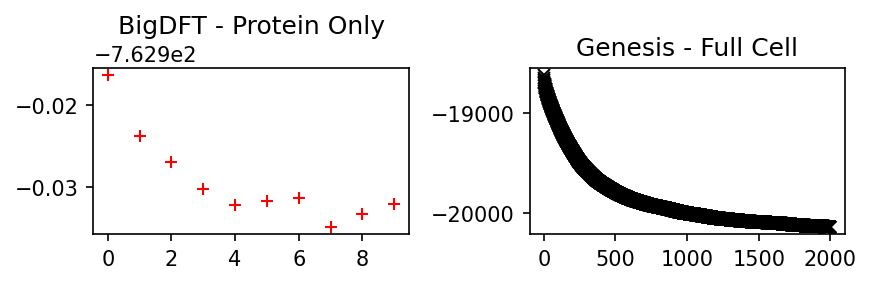

In [11]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=150)
axs[0].plot(dsb.results, 'r+')
axs[0].set_title("BigDFT - Protein Only")
axs[1].plot(dsg.results[0], 'kx')
axs[1].set_title("Genesis - Full Cell")
fig.tight_layout()

We see an initial stage of the protein being internally optimized, followed by what are likely optimizations of the water network. We might take a look at this processes with the fragment bond order.

In [12]:
def reduction(geom):
    from BigDFT.PostProcessing import BigDFTool
    from BigDFT.Logfiles import Logfile
    from BigDFT.IO import read_pdb
    from os.path import join

    tool = BigDFTool()
    # Read in the system
    with open(join("snapshots", f"{geom}.pdb")) as ifile:
        sys = read_pdb(ifile)

    # Log info
    log = Logfile(join("scr", f"log-{geom}.yaml"))
    sys.set_logfile_info(log)

    # Bond Orders
    fbo = tool.fragment_bond_order(sys, list(sys), list(sys), log)

    return fbo

In [13]:
dsf = Dataset(reduction, url=front, name="reduction", asynchronous=False,
              remote_dir=remote_dir, local_dir=local_dir)
for i in range(nsnaps):
    dsf.append_run({"geom": f"1uao-{i}"})
dsf.run() ; dsf. wait() ; dsf.fetch_results()

runner runner-0 already exists
runner runner-1 already exists
runner runner-2 already exists
runner runner-3 already exists
runner runner-4 already exists
runner runner-5 already exists
runner runner-6 already exists
runner runner-7 already exists
runner runner-8 already exists
runner runner-9 already exists
Running Dataset
assessing run for runner reduction-ded468b7-runner-0... ignoring run for successful runner
assessing run for runner reduction-ded468b7-runner-1... ignoring run for successful runner
assessing run for runner reduction-ded468b7-runner-2... ignoring run for successful runner
assessing run for runner reduction-ded468b7-runner-3... ignoring run for successful runner
assessing run for runner reduction-ded468b7-runner-4... ignoring run for successful runner
assessing run for runner reduction-ded468b7-runner-5... ignoring run for successful runner
assessing run for runner reduction-ded468b7-runner-6... ignoring run for successful runner
assessing run for runner reduction-de

Let's figure out which bond orders between non-consecutive amino acids are most relevant.

In [14]:
sign = []
for res in dsf.results:
    for k1 in res:
        fid1 = int(k1.split(":")[1])
        for k2, v in res[k1].items():
            fid2 = int(k2.split(":")[1])
            if fid1 <= fid2:  # only go one directions
                continue
            if fid1 == fid2 + 1:  # no consecutive amino acids
                continue
            if v > 0.01:
                sign.append((k1, k2))
sign = set(sign)

And plot them across snapshots.

In [15]:
from collections import defaultdict
vals = defaultdict(list)
for res in dsf.results:
    for k1, k2 in sign:
        vals[(k1, k2)].append(res[k1][k2] + res[k2][k1])

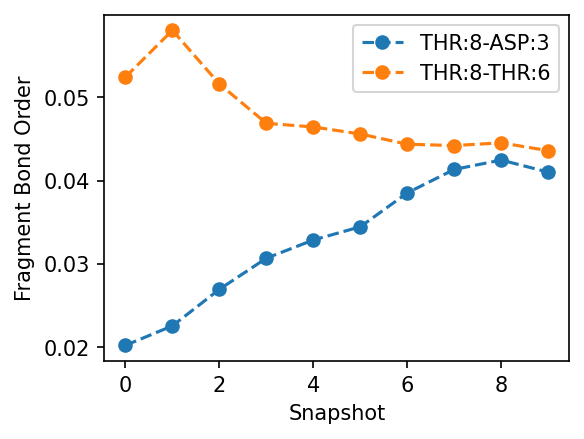

In [16]:
fig, axs = plt.subplots(1, 1, dpi=150, figsize=(4, 3))
for k, v in vals.items():
    axs.plot(v, 'o--', label="-".join(k))
axs.set_ylabel("Fragment Bond Order")
axs.set_xlabel("Snapshot")
_ = axs.legend()

This reveals how the internal energy was stablized by strengthening of the chemical bond between Asp3 and Thr8.

## NTChem
We can also use this workflow with NTChem instead of BigDFT.

In [21]:
from BigDFT.Interop.NTChem.BasisSets import BasisSet, get_symlookup
from BigDFT.IO import read_pdb
with open(f"stream/snapshots/1uao-0.pdb") as ifile:
    sys = read_pdb(ifile)
basis = BasisSet("6-31G*", atoms=get_symlookup(sys))

In [22]:
from calcs import calc_ntchem
from remotemanager.serialisation import serialjsonpickle
dsn = Dataset(calc_ntchem, url=cpu, name="ntchem", serialiser=serialjsonpickle(),
              remote_dir=remote_dir, local_dir=local_dir)

In [23]:
for i in range(nsnaps):
    dsn.append_run({"geom": f"1uao-{i}", "basis": basis, "charge": -2})

appended run runner-0
appended run runner-1
appended run runner-2
appended run runner-3
appended run runner-4
appended run runner-5
appended run runner-6
appended run runner-7
appended run runner-8
appended run runner-9


In [24]:
dsn.run()

Running Dataset
assessing run for runner ntchem-1a68e323-runner-0... running
assessing run for runner ntchem-1a68e323-runner-1... running
assessing run for runner ntchem-1a68e323-runner-2... running
assessing run for runner ntchem-1a68e323-runner-3... running
assessing run for runner ntchem-1a68e323-runner-4... running
assessing run for runner ntchem-1a68e323-runner-5... running
assessing run for runner ntchem-1a68e323-runner-6... running
assessing run for runner ntchem-1a68e323-runner-7... running
assessing run for runner ntchem-1a68e323-runner-8... running
assessing run for runner ntchem-1a68e323-runner-9... running
Transferring 32 Files... Done


In [25]:
dsn.wait() ; dsn.fetch_results()
dsn.fetch_results()

Fetching results
Transferring 20 Files... Done
Fetching results
No Transfer Required


Warning! Found 10 error(s), also check the `errors` property!


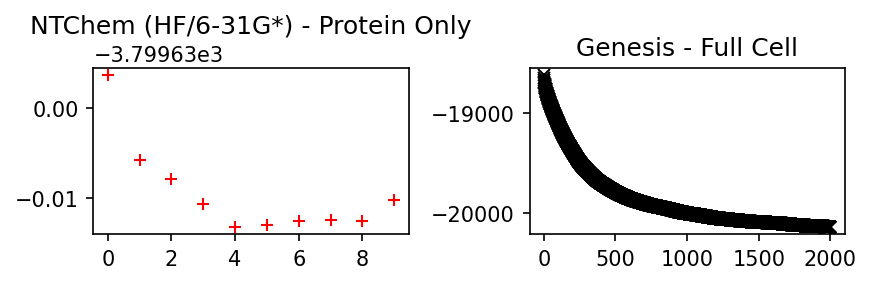

In [26]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=150)
axs[0].plot(dsn.results, 'r+')
axs[0].set_title("NTChem (HF/6-31G*) - Protein Only")
axs[1].plot(dsg.results[0], 'kx')
axs[1].set_title("Genesis - Full Cell")
fig.tight_layout()